# Investigating fine-scale population structure in the 1000 Genomes

## Overview

In the following, we will demonstrate how to perform analyses of population scale genomic data using [Gencove Explorer](https://docs.gencove.com/explorer/).
Broadly, we will explore fine-scale population structure in the form of rare variant sharing between samples deriving from the high-depth whole genome sequencing (WGS) dataset of the combined 1000 Genomes Project (1KG) and Human Genome Diversity Panel (HGDP) released as part of [gnomAD v3.2.1](https://gnomad.broadinstitute.org/downloads#v3-hgdp-1kg).

The following code will be executed on a Gencove Explorer instance; through the use of the [Gencove Explorer SDK](https://docs.gencove.com/explorer/reference/), we will submit a high compute job to the analysis cluster that accompanies each Explorer deployment for data retrieval and processing, before downloading the results to our local instance in order to perform further analysis.

At a high level, we will perform the following steps:

1. Retrieve large multi-sample whole genome sequence datasets pre-stratified by chromosome, and concatenate these into a single multisample VCF representing genetic variation across all samples genome-wide.
2. Extract observations of doubleton sharing across all samples (i.e. instances of genetic variation observed only twice across all samples within the dataset).
3. Retrieve the output of the above to our local instance.
4. Generate a network based representation of doubleton sharing across the entire dataset.
5. Visualize the distributions of doubleton sharing within population groups.
6. Perform unsupervised machine learning over the network of doubleton sharing in order to explore patterns of recent ancestry within the data.


### Introduction

Rare variants comprise the most frequently observed type of genetic variation in human genomes, and have the potential to be informative in genomic studies. Doubletons are a particular class of rare variation defined by being observed only twice across a population of samples. Previous work has demonstrated that the pairwise sharing of such variants between individuals can reflect patterns of recent shared demography, and in turn fine-scale genetic population structure [(Mathieson and McVean, 2014)](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1004528). The demographic information revealed by the analysis of rare variation has broad applications across a variety of sub-fields of human genetics, including adjusting for population structure in genome-wide discovery efforts [(Persyn et al. 2018)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6283567/), accounting for stratification in the calculation of polygenic risk scores [Zaidi and Mathieson, 2020](https://elifesciences.org/articles/61548), understanding patterns of segregation of clinically relevant variation, and elucidating historical relationships between groups via genomic analysis [(Gravel et al 2011)](https://www.pnas.org/doi/full/10.1073/pnas.1019276108).

The ascertainment of genetic variation on genome-wide arrays typically prohibits the analysis of rare variant sharing in an unbiased manner; however with the recent increase in public availability of whole genomes captured via deep sequencing, there are emerging opportunities to explore and further characterize rare variation at the population scale.

Leveraging the Gencove Explorer platform, we will demonstrate how one might characterize patterns of rare genetic variation in population scale whole genome sequence data, and apply unsupervised machine learning in order to extract insights from patterns inherent within the data. 
We do this by utilizing the 1000 Genomes Project and Human Genome Diversity Panel [(Koenig et al. 2023)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9900804/) a globally diverse population-scale dataset comprised of N=4094 whole genomes covering n=77 population groupings, and encompassing over 153 million genetic variants,released as part of GNOMAD v3.2.1.


#### Environment Setup
First, we will start by importing a few key objects from the Gencove Explorer SDK. These will allow us to easily interface between the Explorer deployment's analysis cluster, cloud storage, and our local instance, allowing for easy file access and job submission (for more detailed information on Gencove Explorer and its associated functionalities, please refer to the Explorer documentation [here](https://docs.gencove.com/explorer/)):

In [1]:
from gencove_explorer.analysis import Analysis, AnalysisContext, JobDefinition

#### Defining our Analysis for Data Retrieval and Processing
The `Analysis()` class imported above will allow us to execute and parameterize jobs to be submitted to the cluster.

Since the VCF callset for this release is quite large, we will use Explorer’s [cluster functionality](https://docs.gencove.com/explorer/running_analyses/) to perform the download and initial data preprocessing steps in a job which we will submit to the cluster to be executed remotely.

Before submitting a job, we first specify the code we wish to be executed via a "work function", which always receives an `AnalysisContext` object as input:

In [3]:
def get_hgdp_1kg(ac: AnalysisContext):  
    """Work function to be submitted to Explorer cluster. 
    Retrieves data from Gnomad's GCP repository.
    
    Note the use of the AnalysisContext object here, which provides 
    the job with the necessary context to execute the desired code.
    
    Throughout this function, we'll make use of Jupyter's shell execution 
    capabilities via the '!' operator.
    """
    # The `File` object will be used to register the output files of our analysis
    from gencove_explorer.file import File

    # First install gsutils in order to pull down the data
    print("Getting gsutils\n") 

    # Ensure we have a clean environment
    ! rm -rf $HOME/google-cloud-sdk
    
    # Download the gsutil installation script and execute
    ! curl https://sdk.cloud.google.com | bash -s -- --disable-prompts > /dev/null
    
    # Download the HGDP + 1KG data
    ! $HOME/google-cloud-sdk/bin/gsutil ls gs://gcp-public-data--gnomad/resources/hgdp_1kg/phased_haplotypes_v2/  | while read line ; do $HOME/google-cloud-sdk/bin/gsutil cp ${line} . ; done

    # Download the associated meta data
    ! $HOME/google-cloud-sdk/bin/gsutil cp gs://gcp-public-data--gnomad/release/3.1/secondary_analyses/hgdp_1kg/metadata_and_qc/gnomad_meta_v1.tsv .
    
    # The HGDP + 1KG data comes stratified by chromosome. 
    # We're interested at looking at genome-wide signals of population structure
    # We'll first concatenate the data into a single file representing the whole genome across samples.
    ! bcftools concat *bcf -o hgdp1kgp_all-autosomes.bcf
    
    # We're interested in rare variants for this analysis , so we'll subset the data down to observations of doubletons only.
    ! bcftools view hgdp1kgp_all-autosomes.bcf --max-ac 2 --min-ac 2 -Oz -o hgdp1kgp_all-autosomes.mac2.vcf.gz
    
    # Now we transform our VCF into set lists that retain information of doubleton sharing only (this will be significantly smaller and much easier to work with locally)
    # We do this using plink, which has a useful function to recode a VCF to a "rare genotype list file" (see https://www.cog-genomics.org/plink/1.9/formats#rlist for more details)
    ! wget https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20231211.zip
    ! unzip -o plink_linux_x86_64_20231211.zip
    ! ./plink --vcf hgdp1kgp_all-autosomes.mac2.vcf.gz --recode rlist --out hgdp1kgp_all-doubletons-longlist

    ## Now register the output files so they get automatically uploaded to cloud storage, from where it can be later retrieved
    ac.output.meta_data = File(local=f"gnomad_meta_v1.tsv")
    ac.output.filtered_vcf = File(local=f"hgdp1kgp_all-autosomes.mac2.vcf.gz")
    ac.output.longlist_sharing = File(local=f"hgdp1kgp_all-doubletons-longlist.rlist")

#### Defining the paramters of our cluster job through JobDefinition()
Now that we've defined our analysis via the `AnalysisContext` object, we can specify the compute resources that our job will require through the `JobDefinition` object as follows:

In [18]:
jd = JobDefinition(cpu=32, memory_mb=514688, timeout_seconds=308000)

For this specific job, we request an instance with 32 CPUs and ~52Gb memory, with a high timeout, as we expect this job to take some time.

#### Submitting our analysis as a cluster job

Now, with our analysis and resources both defined, 
we can pass these parameters to the `Analysis()` object to fully define our job:

In [5]:
a = Analysis(
    function=get_hgdp_1kg,
    job_definition=jd
)

And we proceed to submit our analysis to the cluster via:


In [6]:
a.run()

▰▰▰▱▱▱▱ Submitting remote job 

24-04-29 18:33:38 | WARNING | analysis:validate:305 - Storage configuration is ignored when using more than 16.0 cpus.
✅ Remote job submitted        


Analysis(input=[None], function=get_hgdp_1kg, input_shared=None, job_definition=JobDefinition(cpu=32, memory_mb=514688, storage_gb=1000, attempts=1, image=Image(name='362435828402.dkr.ecr.us-east-1.amazonaws.com/explorer-dev-batch'), timeout_seconds=308000, privileged=False), id='2024-05-03T133301_get_hgdp_1kg_a695b8b9799741fa903690782d4136d3', name=None, pip_packages=[], conda_packages=[])

#### Tracking previously submitted jobs

Our analysis is going to take at least a few hours to run. In order to keep track of it we can utilize the `AnalysisManager` class. This will allow us to retrieve any previously submitted job, easily monitor the status of our submitted job, and retrieve any associated log output.

You can find more details on this specific function under the following [link](https://docs.gencove.com/explorer/running_analyses/#persistence-with-the-analysismanager-object).

In the above example, a unique `id` for the analysis was generated when `a.run()` was called. The `id` in the above case was `2024-05-03T133301_get_hgdp_1kg_a695b8b9799741fa903690782d4136d3`. This `id` value can be used to track the status of 
our job as follows:

In [2]:
from gencove_explorer.analysis_manager import AnalysisManager
mgr = AnalysisManager()

# Retrieve the analysis object - this is the same `a` object as defined earlier 
doubleton_analysis = mgr.get_analysis(analysis_id="2024-05-03T133301_get_hgdp_1kg_a695b8b9799741fa903690782d4136d3")

Note we've specified the analysis we wish to monitor by providing the `AnalysisManager` instance with the analysis `id` that was output earlier.

We can now check on the status of our job:

In [17]:
doubleton_analysis.status()

{
    "status": "RUNNING",
    "attempts": 0,
    "status_reason": "None.",
    "exit_code": None,
    "started_at": "2024-04-29 18:38:26",
    "stopped_at": None,
}


We can also request a print of the log output as the job runs as follows: 

In [3]:
doubleton_analysis.logs()

### Exploring doubleton sharing across HGDP + 1KG

Submitting the above code launched a job to download and process our WGS data prior to further downstream analyses.
After giving the job some time to run, we are able to retrieve our desired output via the following code, which utilizes Explorer's ``File()`` object. ``File()`` allows us to interface with files saved to S3, URLs, and files uploaded within a cluster job to the [Explorer Object Store](https://docs.gencove.com/explorer/storage/#cloud-storage-eos), as in our case here. More information on ``File()`` can be found [here](https://docs.gencove.com/explorer/storage/).

In [6]:
doubleton_analysis.get_output(0).longlist_sharing.download(local="hgdp1kgp_all-doubletons-longlist.rlist", force=True)
doubleton_analysis.get_output(0).meta_data.download(local="gnomad_meta_v1.tsv", force=True)

File(local=PosixPath('gnomad_meta_v1.tsv'), remote=EFile(path='e://users/me/tmp/3b844ccbcd0446e8a50d199de33e4f5c'))

We can take a quick look at the format of our output file of doubletons:


In [74]:
! head hgdp1kgp_all-doubletons-longlist.rlist

. HET G A HG02077 HG02077 HG02079 HG02079
. HET T C LP6005443-DNA C02 HG00369 HG00369
. HET C CCT HG02856 HG02856 HG02855 HG02855
. HET A G HGDP01207 HGDP01207 HG02278 HG02278
. HET A G HGDP01313 HGDP01313 HG00956 HG00956
. HET C T NA19914 NA19914 HG02497 HG02497
. HET A G HG03248 HG03248 HG03246 HG03246
. HET T C HG03230 HG03230 HG03228 HG03228
. HET T C LP6005441-DNA B11 SS6004473 SS6004473
. HET C G LP6005441-DNA E05 HG01551 HG01551


In the above file, every row represents a doubleton. Column entries after column 4 represent the Individual and Family IDs of samples within the dataset who mutually carry that doubleton.

Let's first count up the numbers of doubletons shared by pairs of individuals so we can start to examine the distributions.
First, some individuals are homozygous for doubleton calls, this isn't telling us anything about who they share rare variants with, so let's filter those rows out, and then sum up the number of doubletons shared by each remaining pair, as follows:

In [ ]:
overall = {} # make a dictionary where we'll store out counts
with open("hgdp1kgp_all-doubletons-longlist.rlist", "r") as rlist:
	for line in rlist:
		items = line.strip().split()
		forwards = (" ".join(items[4:6]) + " " + " ".join(items[6:])) # grab IDs for individual 1
		backwards = (" ".join(items[6:]) + " " + " ".join(items[6:5])) # grab IDs for individual 2
		if len(items) > 6: # skip lines of doubletons carried by only one individual 
			if forwards not in overall and backwards not in overall:
				overall[forwards]= {"count": 1}
			else:
				prior_count = overall[forwards]["count"]
				updated_count = 1 + prior_count
				overall[forwards] = {"count": updated_count}

# Write our counts to a new file
with open("pairwise-doubleton-count.txt", "w") as g:
    for item in overall:
        g.write(str(item) + " " + str(overall[item]["count"]) + '\n')

Now, taking a quick look at the final file:

In [20]:
! head pairwise-doubleton-count.txt

HG00097 HG00097 HG00096 HG00096 47
HG00099 HG00099 HG00096 HG00096 23
HG00100 HG00100 HG00096 HG00096 16
HG00101 HG00101 HG00096 HG00096 96
HG00102 HG00102 HG00096 HG00096 34
HG00103 HG00103 HG00096 HG00096 9
HG00105 HG00105 HG00096 HG00096 3
HG00106 HG00106 HG00096 HG00096 14
HG00107 HG00107 HG00096 HG00096 47
HG00108 HG00108 HG00096 HG00096 24


What we have in this file now is a list where the first four entries of every row represent a pair of samples (corresponding to the Family IDs and Sample IDs for each pair), and the fifth column represents the number of doubletons shared by that pair. Now, we can link this to the available sample meta-data and explore correlations with population labels. 

First, we map on the population meta-data; since this dataset contains some related individuals, we make sure also to exclude one of each pair of related individuals, as we expect direct relatives to share a lot of rare variants, which may influence the overall distributions:

In [5]:
POP = {}  # dictionary for population labels
REL = []  # list of samples designated as related (for exclusion)

# Read in metadata and store relevant info
with open("gnomad_meta_v1.tsv", "r") as f:
    gnomad_lines = f.readlines()

for line in gnomad_lines:
    line = line.strip()
    id = line.split("\t")[0]  # sample id
    related = line.split("\t")[140]  # index for whether part of related set as boolean
    pop_labs = line.split("\t")[175:177]  # labels for geographical regions of samples
    if related == 'true':
        REL.append(id)
    POP[id] = pop_labs

# Read in our list of doubleton sharing, map on sample metadata and exclude lines containing related individuals
with open("pairwise-doubleton-count-mapped.no-relateds.txt", "w") as m:
    with open("pairwise-doubleton-count.txt", "r") as f:
        pairwise_lines = f.readlines()
    for line in pairwise_lines:
        line = line.strip().split()
        id1 = line[0]
        if "DNA" in id1:
            id1 = "_".join(line[0:2])
        id2 = line[2]
        if "DNA" in id2:
            id2 = "_".join(line[2:4])
        doubletons = line[4]
        if (id1 in REL) or (id2 in REL):
            continue
        else:
            if (id1 in POP) and (id2 in POP):
                m.write(
                    id1 + "\t" + id2 + "\t" + doubletons + "\t" + "\t".join(POP[id1]) + "\t" + "\t".join(POP[id2]) + "\n")

We now have a list of pairwise doubleton sharing with the population labels available in HGDP + 1KG joined on:

In [22]:
! head pairwise-doubleton-count-mapped.no-relateds.txt

HG00097	HG00096	47	GBR	EUR	GBR	EUR
HG00099	HG00096	23	GBR	EUR	GBR	EUR
HG00100	HG00096	16	GBR	EUR	GBR	EUR
HG00101	HG00096	96	GBR	EUR	GBR	EUR
HG00102	HG00096	34	GBR	EUR	GBR	EUR
HG00103	HG00096	9	GBR	EUR	GBR	EUR
HG00105	HG00096	3	GBR	EUR	GBR	EUR
HG00106	HG00096	14	GBR	EUR	GBR	EUR
HG00107	HG00096	47	GBR	EUR	GBR	EUR
HG00108	HG00096	24	GBR	EUR	GBR	EUR


Here, the first three columns represent pairs of individuals and the number of doubletons that they share. The following four columns represent the Continental and more granular geographical labels that are associated with those samples.
Since we expect counts of doubleton sharing to be impacted by recent demography, we can start to explore this by examining the distributions of doubleton sharing within pairs of individuals belonging to the same population label:

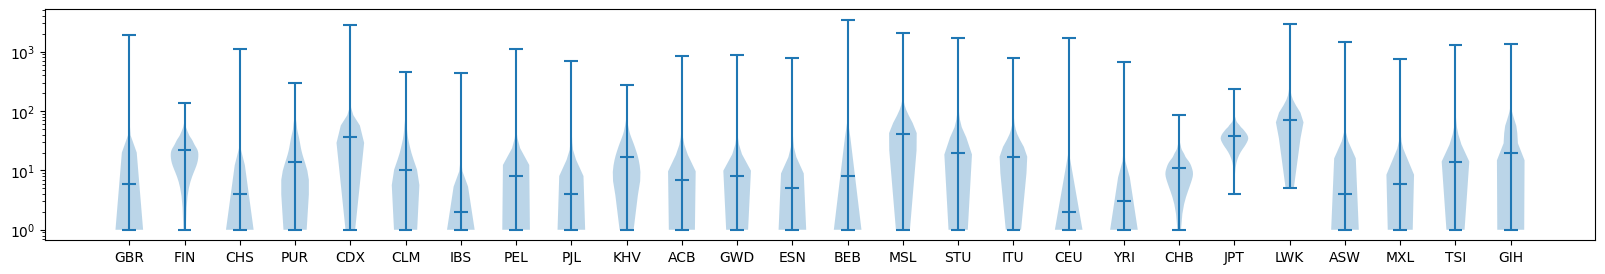

In [3]:
import matplotlib.pyplot as plt

# Make a quick plot of the distribution of doubleton sharing across the remaining dataset
COUNT = {}
with open("pairwise-doubleton-count-mapped.no-relateds.txt", "r") as f:
    doubletons = f.readlines()

for line in doubletons:
    line = line.strip()
    label1 = line.split("\t")[3]
    label2 = line.split("\t")[5]
    doubleton_counts = line.split("\t")[2]
    
    # Let's start by looking at distributions of sharing within individuals with the same label    
    if label1 == label2:
        if label1 not in COUNT:
            COUNT[label1] = []
            COUNT[label1].append(int(doubleton_counts))
        else:
            COUNT[label1].append(int(doubleton_counts))

# For the purposes of visualization, lets subset down to some of the groups with the largest N (>50)
KEEP = ["ACB","ASW","BEB","CDX","CEU","CHB","CHS","CLM","ESN","FIN","GBR","GIH","GWD","IBS","ITU","JPT","KHV","LWK","MSL","MXL","PEL","PJL","PUR","STU","TSI","YRI"]

SUBSET = {}
for key in COUNT:
    if key in KEEP:
        SUBSET[key] = COUNT[key]

labels, data = SUBSET.keys(), SUBSET.values()
plt.figure(figsize=(20, 3))
plt.violinplot(data, showmeans=False, showmedians=True)
plt.xticks(range(1, len(labels) + 1), labels)
plt.yscale("log")
plt.show()

Here, the y-axis is the number of doubletons shared by a pair (on a log scale), and each violin plot represents the distribution of pairwise sharing within a given population grouping.

We see differences in the median number of doubletons shared between individuals when comparing across population labels.

Expectations of doubleton sharing within populations are contingent on their demographic history. Note, for example, that the Finnish samples (FIN), share on average, more doubletons, than other European ancestry groups (e.g. GBR). This is potentially due to the fact that individuals from founder populations are more likely to share rare genetic variation, than individuals from populations that have not undergone a founder effect in recent history.


### Unsupervised learning across a network of doubleton sharing

We expect there to be an enrichment of sharing of doubletons between individuals that are more closely related to one another than those that are more distantly related. We can use machine learning methods to try and learn from the patterns of doubleton sharing we see in our data.

To this end, we will begin by running a community detection algorithm over our network of doubleton sharing. This will involve first reformatting our data to represent a network. Following this, we'll run the Python implementation of the map equation (``infomap``) over our network to determine whether patterns of rare variant sharing are reflective of population structure. For more information about `infomap`, see the documentation [here](https://mapequation.github.io/infomap/python/).

First of all, we're going to reformat our list of doubleton sharing to the input format required by ``infomap``:


In [2]:
import numpy as np

# We first need to grab all IDs represented in our network
VERTICES = []
for line in doubletons:
    line = line.strip()
    id1 = line.split("\t")[0]
    id2 = line.split("\t")[1]
    VERTICES.append(id1)
    VERTICES.append(id2)

# Subset down to the set of unique IDs and assign them an index
VERTICES = set(VERTICES)
INDEX = []
for x in VERTICES:
    INDEX.append(x)

# Now read in our edges and save as a dict
EDGES = {}
for line in doubletons:
    line = line.strip()
    id1 = line.split("\t")[0]
    id2 = line.split("\t")[1]
    edge = int(line.split("\t")[2])
    key = str(INDEX.index(id1) + 1) + ":" + str(INDEX.index(id2) + 1)
    # We're going to subset our graph to edges where individuals share at least 3 doubletons for community detection
    if edge >= 3:
        # We're also going to transform our edge weights to a log10 scale here
        EDGES[key] = np.log10(edge)


Now we write out the format that ``infomap`` will read in:
* This begins with the number of vertices present in our network as line number one.
* This line is followed by an index for each vertex that is linked to its sample ID.
* Following this we print out the total number of edges present in our network.
* Finally, a representation of the graph where IDs have been substituted for their vertex index, with the first two columns being each pair of vertices, and the final column representing that pairs respective edge weight.

In [4]:
with open("infomap-community-detection.net", "w") as infomap:
    infomap.write("*Vertices " + str(len(INDEX)) + "\n")
    for x in INDEX:
        infomap.write(str(INDEX.index(x) + 1) + " " + f'"{str(x)}"' + "\n")
    infomap.write("*Edges " + str(len(EDGES)) + "\n")
    for key in EDGES:
        keypair = key.replace(":"," ")
        infomap.write(str(keypair) + " " + str(EDGES[key]) + "\n")

We now need to install ``infomap``, which we can do via ``pip``:

In [ ]:
! pip install infomap

We're now going to run community detection over the network of doubleton sharing.

``infomap`` is a flow based community detection algorithm that is able to define substructure (communities) within networks, based on network dynamics. 

We're going to run it over the doubleton network, while tweaking a couple of parameters; specifically:
* We're specifying to treat our network as undirected.
* We're asking it to run 10 trials to pick the optimal solution.
* We're setting a slightly lower Markov time than the default (smaller values tend to produce more granular communities).

In [7]:
! infomap infomap-community-detection.net  . -N10 -f undirected --markov-time 0.7

  Infomap v2.7.1 starts at 2024-04-24 01:34:05
  -> Input network: infomap-community-detection.net
  -> Output path:   ./
  -> Configuration: flow-model = undirected
                    markov-time = 0.7
                    num-trials = 10
  OpenMP 201511 detected with 8 threads...
Parsing undirected network from file 'infomap-community-detection.net'...
  Parsing vertices...
  -> 3387 physical nodes added
  Parsing links...
  -> 666409 links
Done!
-------------------------------------
  -> 3387 nodes
  -> 666409 links with total weight 558994.587
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 3387 nodes and 666409 links...
  -> Rescale link flow with global Markov time 0.7
  -> One-level codelength: 11.5860124

Trial 1/10 starting at 2024-04-24 01:34:08
Two-level compression: 16% 0.0004% 
P

#### Exploring recovered communities of rare variant sharing

The output of the community detection algorithm wrote out to the output file ``infomap-community-detection.tree``; we can take a quick look at the output format:

In [8]:
! head -15 infomap-community-detection.tree

# v2.7.1
# ./Infomap infomap-community-detection.net . -N10 -f undirected --markov-time 0.7
# started at 2024-04-24 01:34:05
# completed in 51.0463 s
# partitioned into 3 levels with 13 top modules
# codelength 9.9626 bits
# relative codelength savings 14.0119%
# flow model undirected
# path flow name node_id
1:1 0.000508802 "HGDP00712" 2733
1:2 0.00050769 "HGDP01096" 3329
1:3 0.000506284 "HGDP00714" 2344
1:4 0.000505204 "NA18549" 2075
1:5 0.000503554 "HGDP00784" 873
1:6 0.000501138 "NA18582" 2436


After the header, you'll see four columns. The two we're interested in are the first column, ``path`` (which contains our community designations), and the third column, ``name``, which is our sample ID.
In theory, individuals who are likely to have recent historical relationships should share more rare variants than those who don't.
To see whether the communities to which these samples have been assigned might represent population substructure, we can compare them to available population labels.


In [9]:
# Now make two new dictionaries
# The purpose of this is to count up the pre-specified population labels that fall into each community assignment
CONTINENT = {}
SUB_CONT = {}

# Specify our output file
with open("infomap-community-detection.tree.with-meta-data.txt", "w") as meta:
    # Read in the output from infomap
    for line in open("infomap-community-detection.tree", "r"):
        line = line.strip()
        if "#" in line:  # skip the header (prefixed with #)
            pass
        else:
            top_com = line.split(" ")[0].split(":")[0]  # grab the community designation per sample
            id = line.split(" ")[2]   # grab the sample ID
            id = id.replace('"', '')  # strip away the quotes
            if id in POP:
                # Populate our two dictionaries
                # we're setting the key to be one of our communities defined by infomap
                # then, for every individual we're appending on their pre-defined population labels, so we can count them up per community
                if top_com not in CONTINENT:
                    CONTINENT[top_com] = []  # initiate list for each community
                    CONTINENT[top_com].append(POP[id][1])  # append population label to list
                    SUB_CONT[top_com] = []
                    SUB_CONT[top_com].append(POP[id][0])
                else:
                    CONTINENT[top_com].append(POP[id][1])
                    SUB_CONT[top_com].append(POP[id][0])
                meta.write(top_com + " " + " ".join(POP[id]) + "\n")  # write out a file containing the community assignments joined to the available population meta-data

We can now look at community assignments, and whether they correlate with the available populations labels. Our ``CONTINENT`` dictionary contains the continental label for each sample assigned to a specific community, while the ``SUB_CONT`` dictionary contains the same information for the more fine-scale population labels.
First, we can take a quick look at the counts of individuals from a particular continental label that have been assigned to each community as follows:

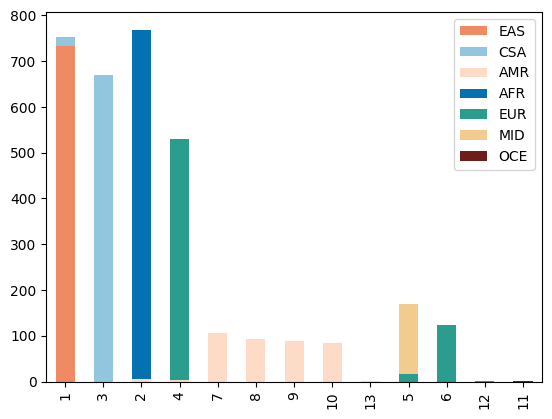

In [10]:
from collections import Counter
import pandas as pd

count_dict = {k: Counter(v) for k, v in CONTINENT.items()}
continent_table = pd.DataFrame.from_dict(count_dict, orient="index").fillna(0).astype("int")
pal = ["#ef8a62", "#92c5de", "#fddbc7", "#0571b0", "#2a9d8f", "#f2cc8f", "#6f1d1b"]
continent_table.plot.bar(stacked=True,color=pal)

#### Results of comparison between detected communities and Continental population labels
The plot is a stacked barplot representing the counts of individuals with a given continental label that fall into each of our detected communities. The X axis comprises an integer that represents each community from our community detection analysis. The Y axis represents the count of individuals with a particular known label that fall within each community.

We uncover 13 communities in the data in total. Broadly, we see that community assignments for each individual are highly correlated with their continental group labelling (that is, individuals with the same continental label tend to have been assigned to the same ``infomap`` community).

Digging a little further, we see that:
* Community 1 mostly comprises East Asian (EAS) samples.
* Community 2 mostly comprises Central South Asian (CSA) samples.
* Community 3 mostly comprises African (AFR) samples.
* We see two distinct communities for European (EUR) samples, specifically 4 and 6.
* Community 5 comprises samples from the Middle East (MID) and a small proportion from Europe (EUR).
* We see multiple distinct communities (e.g. 7 through 10) that entirely comprise samples from the Americas (AMR).
* Communities 11, 12 and 13 each only contain one individual, suggesting that they may not share recent ancestry with the other remaining samples in the HGDP + 1KG dataset.

This observation is in keeping with our hypothesis that individuals that are geographically proximal to one another are more likely to have recent shared ancestry, and thus are enriched for genetic sharing of doubletons.

#### Correspondence between community membership and sub-continental population labels

We can also take a look at relationship between the more fine-scale labels from our analysis to see whether the detected community structure reveals anything of further interest.

Below, we will perform a similar analysis but in this instance using the more fine-grained (sub-continental) population labels available for the HGDP + 1KG dataset.

Because there are a total of 77 possible sub-continental labels, instead of visualizing this as a stacked bar plot, we will instead report the results as a table.


In [11]:
from IPython.display import display, HTML
count_dict_s = {k: Counter(v) for k, v in SUB_CONT.items()}
sub_table = pd.DataFrame.from_dict(count_dict_s, orient="index").fillna(0).astype("int")
display(HTML(sub_table.to_html()))

,Cambodian,Tujia,CHB,Han,KHV,Tu,Xibo,CHS,CDX,Uygur,Miao,Yi,Mongola,Hazara,Naxi,Hezhen,Daur,She,Oroqen,Dai,JPT,Lahu,Japanese,Yakut,PEL,San,BantuSouthAfrica,BantuKenya,BiakaPygmy,ASW,MbutiPygmy,LWK,ACB,MSL,Yoruba,Mandenka,GWD,ESN,YRI,PUR,CLM,BEB,STU,ITU,GIH,Sindhi,Pathan,PJL,Balochi,Burusho,Makrani,Brahui,Kalash,TSI,Tuscan,IBS,French,Italian,GBR,CEU,Sardinian,Orcadian,Basque,MXL,Bedouin,Palestinian,Druze,Adygei,Mozabite,Russian,FIN,Colombian,Karitiana,Surui,Pima,Maya,Papuan
1,10,10,103,43,101,10,9,105,92,6,10,10,10,18,8,9,9,9,8,9,102,8,28,25,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,101,102,102,101,23,24,103,23,24,22,23,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,8,10,21,53,8,95,94,88,21,21,117,105,118,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,97,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,2,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,103,8,104,27,11,90,119,27,15,23,2,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,92,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,0,0,0,0,0,0,0,0,0,0,6,21,0
13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Results of comparison between detected communities and subcontinental population labels

In the table above, each row represents a community defined via ``infomap`` and each column represents a granular population label derived from the meta data provided with the HGDP + TGP dataset. The numbers in each field represent the number of individuals with a given popuation label that fall within a specific community.
We're now beginning to see that community membership correlates with more fine-scale population structure:

* We now see, for example that community 4 comprises most European groups in the 1KG + HGDP data.
* Community 6 is a distinct group comprising the Finnish (FIN) and Russian samples.
* We see a distinct community (8) for Columbian (CLM) samples.
* Community 7 is majority Puerto Rican (PUR).
* Community 9 comprises the Mexican (MXL), Pima and Maya samples.
* Community 10 exclusively comprises the Peruvian (PEL) samples.


We see that by performing community detection on networks of doubletons in an unsupervised manner, we are able to delineate granular structure within our data that is highly concordant with population history and recent relationships between population groupings.

## Conclusions

Here we have demonstrated how to perform population scale analysis of a large dataset of whole-genome sequence data by leveraging the Explorer SDK, the Explorer Object Store, and the analysis cluster that accompanies every Explorer deployment. We were able to retrieve and process a large, population-scale dataset of whole genome sequence data in a job submitted to the cluster, retrieve the output of the analysis, and create visualizations within a single Jupyter notebook. By analyzing patterns of rare variant sharing, we were able to explore patterns of population structure in the diverse 1KG + HGDP dataset via unsupervised machine learning over doubleton sharing and uncover communities of individuals enriched for sharing of rare variants. Lastly, we demonstrated that these correlate with available populations labels for the 1KG + HGDP data.

All analysis was performed in Gencove Explorer. Learn more by clicking [here.](https://docs.gencove.com/explorer/)